In [2]:
using ElectronPropagation
using PyPlot
using FFTW

smoothe(A, x, y, σ) = ifftshift(ifft(fft(A) .* fft(@. exp(-(x^2+y'^2)/σ^2))))
;

In [3]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 10
minval = 0.5
maxval = 1.0
cmap = get_cmap("PuOr")
violett = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
cmap = get_cmap("seismic")
red = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
norm = PyPlot.matplotlib.colors.Normalize(vmin=0, vmax=1)
;

In [4]:
U = 30e3

L = 50e-6
z = 0.5
w = 15e-6  # electron beam radius

λ = deBroglieWavelength(U)

# sampling
Δx = λ * z / L / 10

display(Δx)

x = Vector{Float64}(range(-L/2, L/2-Δx, step=Δx))
y = copy(x)
;

6.979081574270336e-9

In [104]:
FWHM = 4.3e-6
wgauss = FWHM / 2.355
#wgauss = 10e-6
gauss_sep = 6e-6

λ_l = 1035e-9
E = 70e-9

ximg = Vector{Float64}(range(-8e-6, 8e-6, step=0.02e-6))
yimg = Vector{Float64}(range(-16e-6, 16e-6, step=0.02e-6))

I = @. (exp(-ximg^2/2/wgauss^2 - (yimg'-gauss_sep/2)^2/2/wgauss^2 )
        + exp(-ximg^2/2/wgauss^2 - (yimg'+gauss_sep/2)^2/2/wgauss^2 ) )

#I = @. exp(-ximg^2/2/wgauss^2 - yimg'^2/2/wgauss^2 )

lb = LaserBeam(I, λ_l, E, ximg, yimg)

ψ = smoothe([i^2 + j^2 < w^2 ? complex(1.) : complex(0.) for i in x, j in y], x, y, 1e-6)
extent_e = [x[1], x[end], y[1], y[end]].*1e6

eb = ElectronBeam(ψ, U, x, y)
phase_imprint = PhaseImprint(lb)
free = Free(eb, z)
setup = Setup(phase_imprint, free)
propagation!(eb, setup)

out_int = abs2.(eb.ψ)
;

In [105]:
n, m = size(I)
I_cross = I[round(Int, n/2)+1, :]
ffset = 0.1
func(x) = x > 0.5
bounds = findall(func, I_cross)

#display(yimg[bounds[end]]-yimg[bounds[1]])
#plot(yimg, I_cross)
;

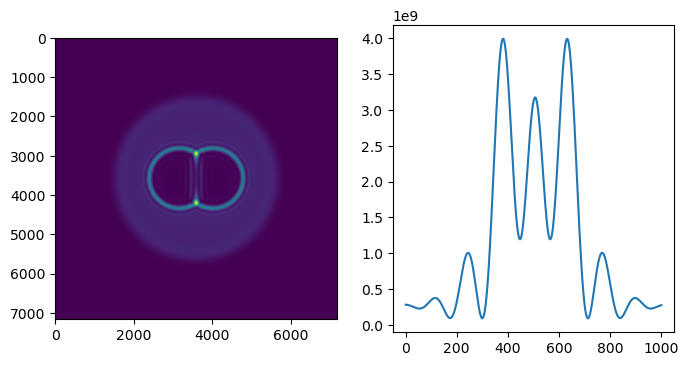

In [106]:
# plotting
cross = out_int[round(Int, size(out_int, 1)/2),
                round(Int, size(out_int, 2)/2)-500:round(Int, size(out_int, 2)/2)+500]

pygui(false)
figsize = [20, 10] / 2.504
fig, (ax1, ax2) = subplots(1, 2, figsize=figsize)
ax1.imshow(out_int)
ax2.plot(cross);

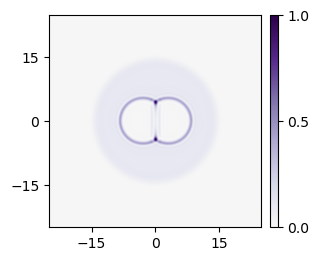

In [107]:
out = out_int ./ maximum(out_int)
out[1, 1] = 0

savestring = ("gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"E"*string(round(Int, E*1e9))*"_picture.svg")

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize)
plt = ax.imshow(out, cmap=violett, extent=extent_e)

#ax.set_xlabel("µm")
#ax.set_ylabel("µm")

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)
savefig("./images/two_gauss_sym/"*savestring, bbox_inches="tight", dpi=300)
;

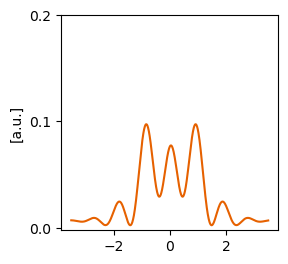

In [112]:
fov = 1000
cross = out[round(Int, size(out_int, 1)/2),
            round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)]
xcross = x[round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)] .* 1e6

savestring = ("gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"E"*string(round(Int, E*1e9))*"_cross.svg")

figsize = [7, 7] ./ 2.504

pygui(false)
fig, ax = subplots(figsize=figsize)
ax.plot(xcross, cross, color="#E66100")

ax.set_yticks([0, 0.1, 0.2])
ax.set_xticks([-2, 0, 2])

#ax.set_xlabel("µm")
ax.set_ylabel("[a.u.]")

savefig("./images/two_gauss_sym/"*savestring, bbox_inches="tight")
;

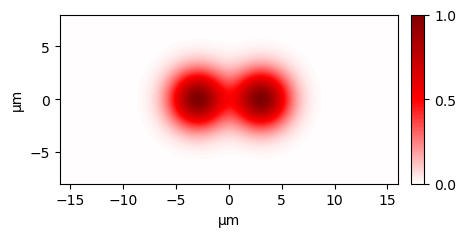

In [87]:
int_plot = I
int_plot[1, 1] = 0
int_plot ./= maximum(int_plot)

figsize = [11, 5.5] ./ 2.504
extent = [yimg[1], yimg[end], ximg[1], ximg[end]].*1e6

pygui(false)
fig, ax = subplots(figsize = figsize)
plt = ax.imshow(I, cmap=red, extent=extent)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

savefig("./images/two_gauss_sym/double_gaussian.svg", bbox_inches="tight", dpi=300)
;

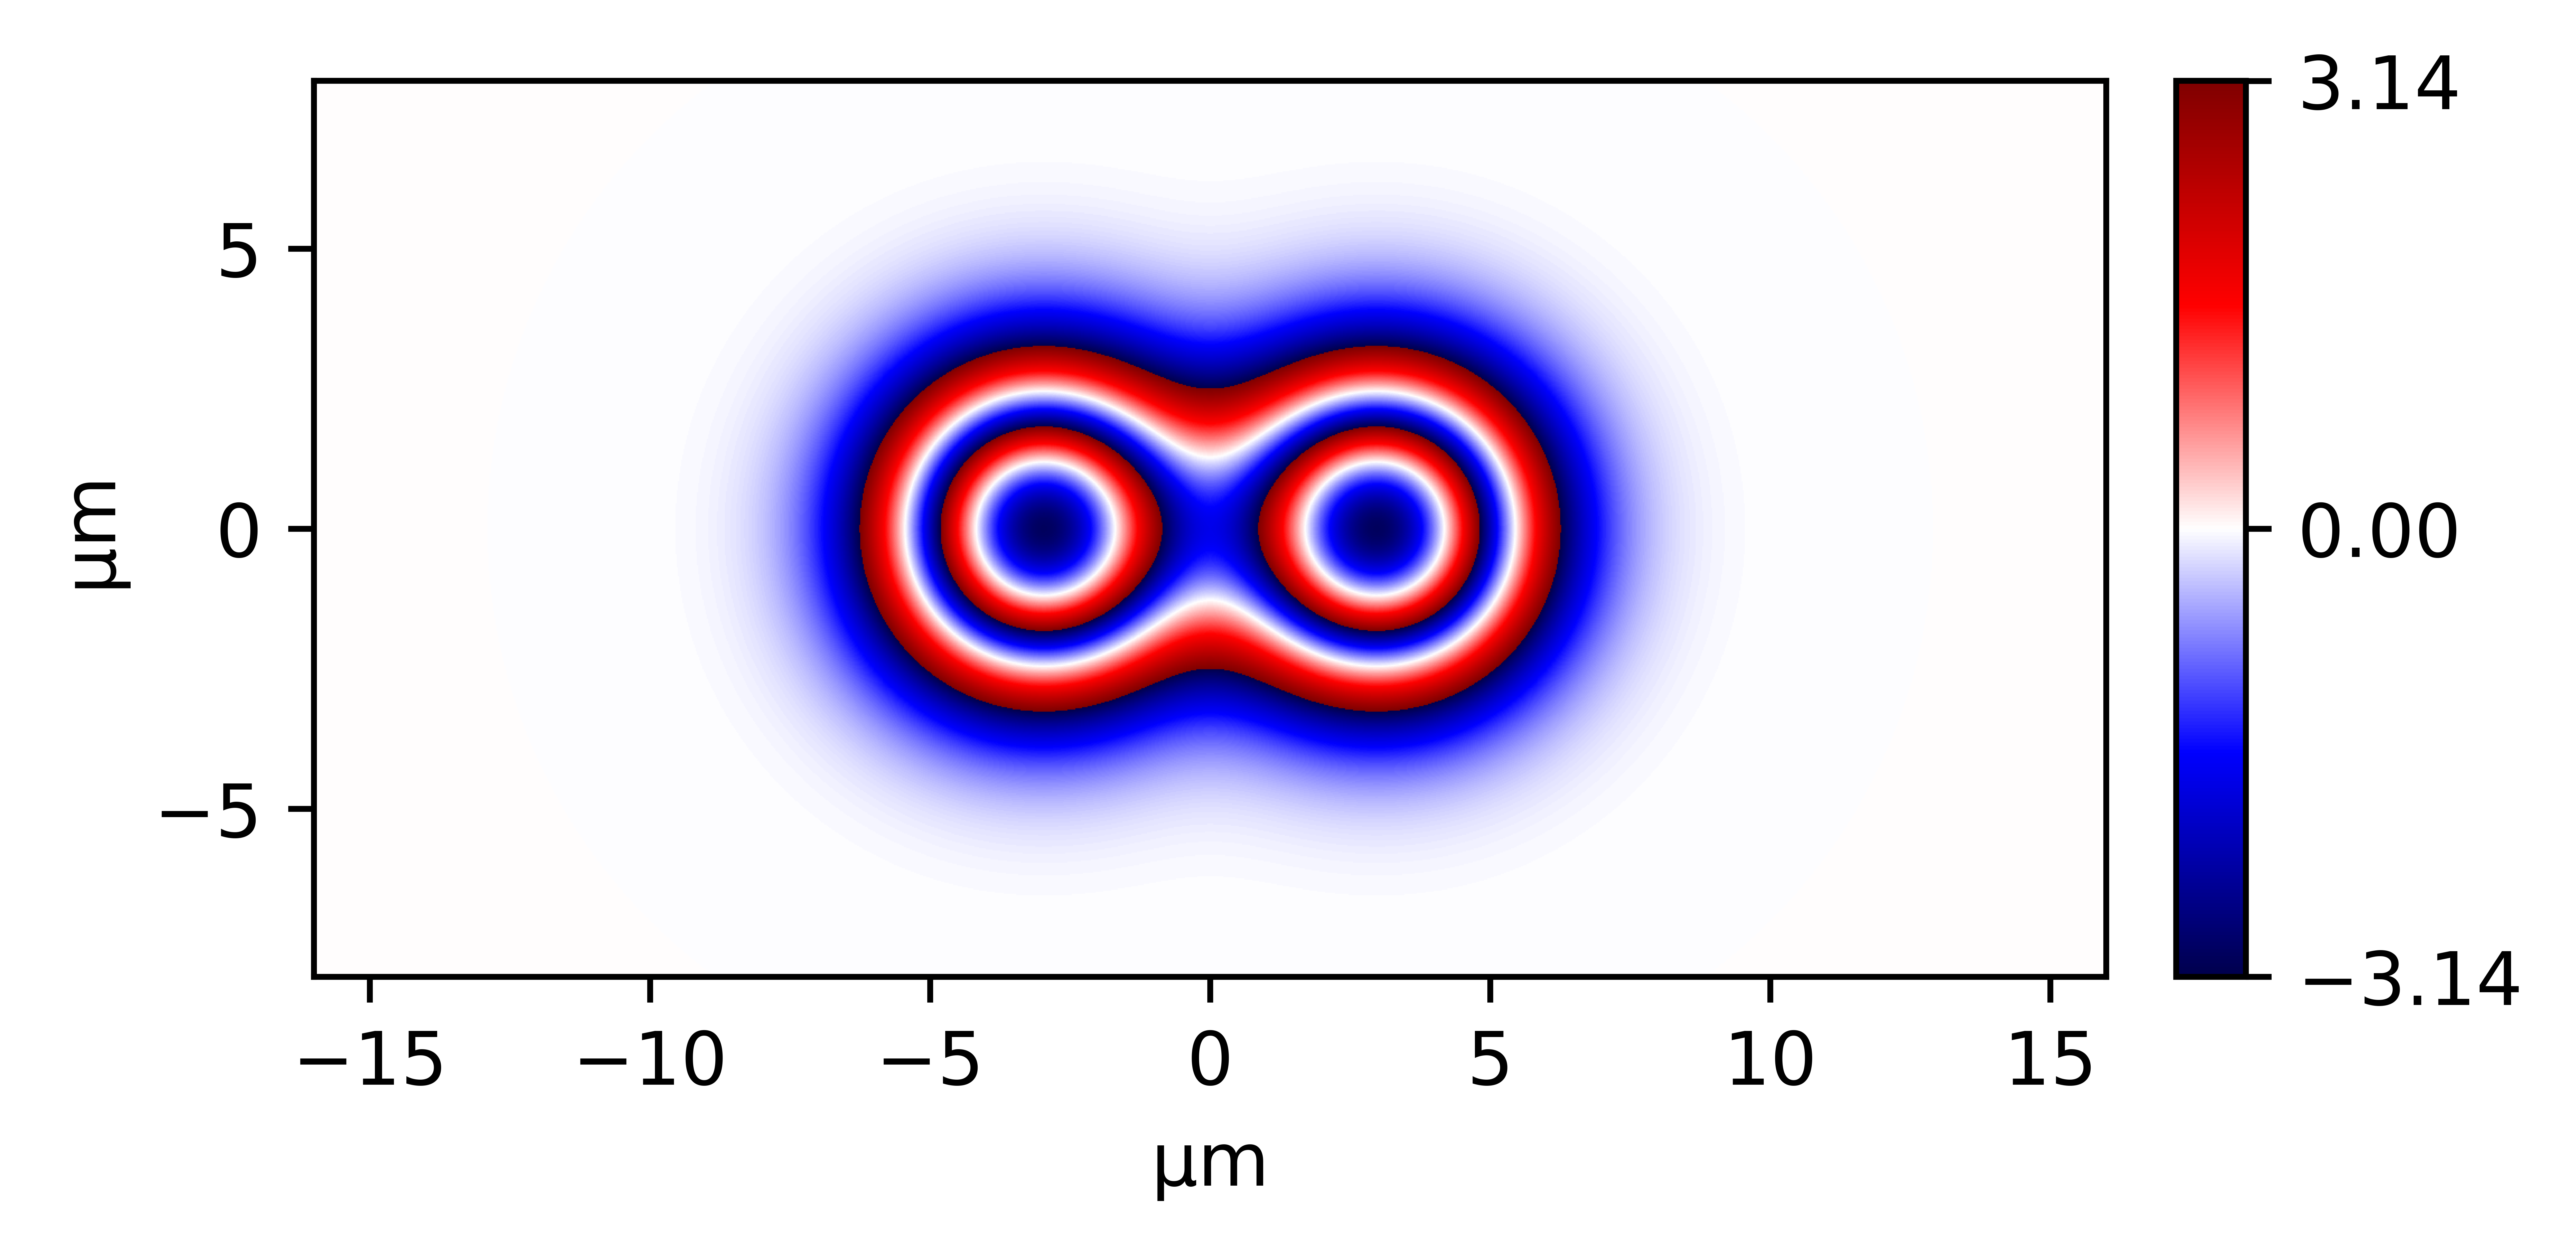

In [89]:
int_plot = I
int_plot[1, 1] = 0
int_plot ./= maximum(int_plot)

eb_plane = ElectronBeam(ones(ComplexF64, size(I)), U, ximg, yimg)
setup = Setup(PhaseImprint(lb))
propagation!(eb_plane, setup)

figsize = [11, 5.5] ./ 2.504
extent = [yimg[1], yimg[end], ximg[1], ximg[end]].*1e6

pygui(false)
fig, ax = subplots(figsize = figsize, dpi=2000)
plt = ax.imshow(angle.(eb_plane.ψ), cmap="seismic", extent=extent)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[-3.14, 0, 3.14], cax=cax)

savefig("./images/two_gauss_sym/double_gaussian_phase.svg", bbox_inches="tight", dpi=2000)
;